In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
def dNbydM(m,p0,p1,p2):
    return p0*(1-(m/13))**p1/(m/13)**p2

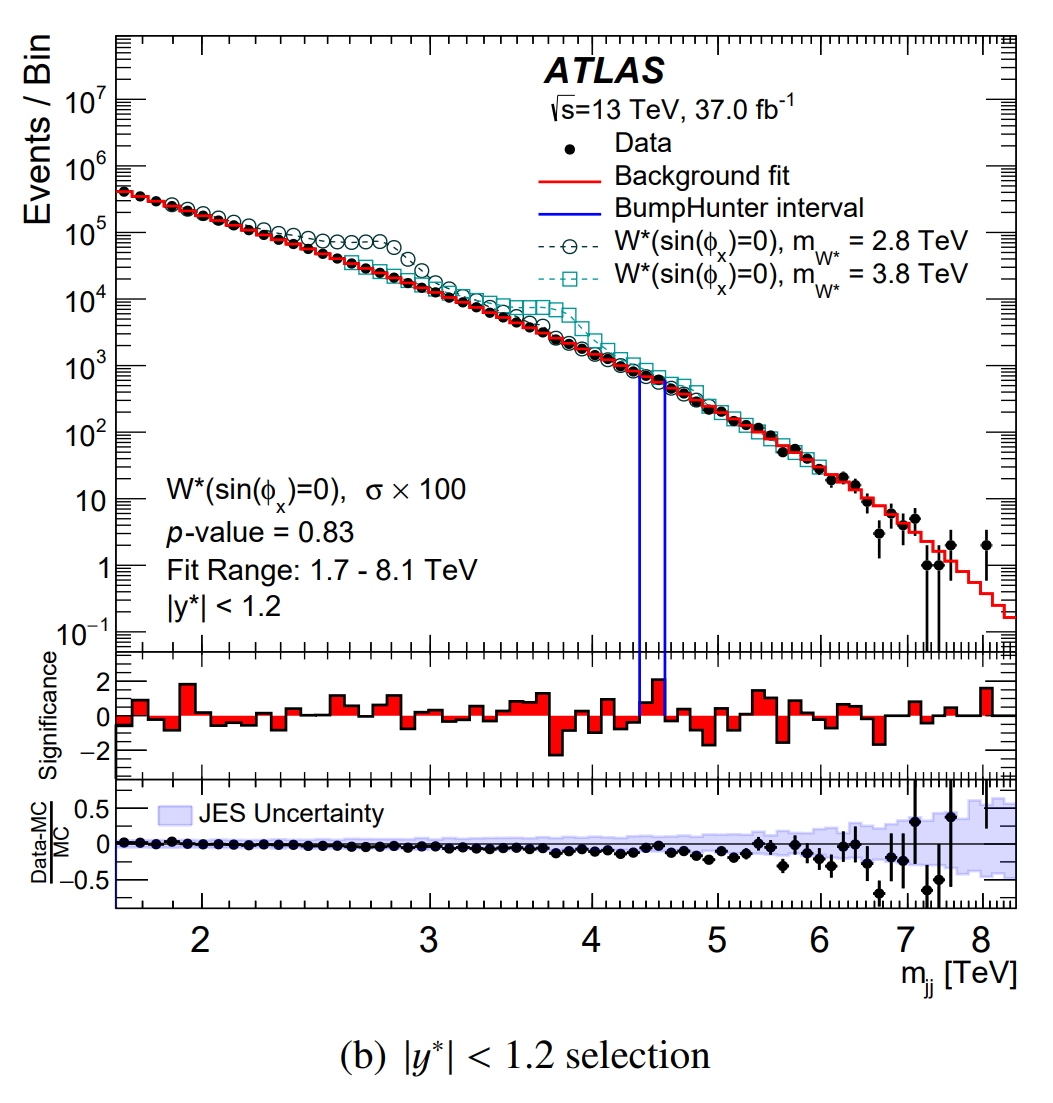

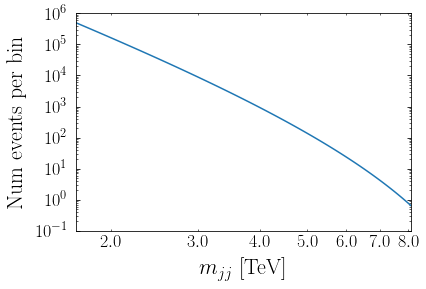

In [3]:
p0 = 0.5*10**1
p1 = 5.
p2 = 6.
x = np.arange(1.7,8.11,0.1)
y = [dNbydM(m,p0,p1,p2) for m in x]
plt.plot(x,y)
plt.semilogy()
plt.semilogx()
plt.xlabel(r"$m_{jj}$  [TeV]")
plt.ylabel("Num events per bin")
plt.xlim([1.7,8.1])
plt.ylim([10**-1,10**6])
ax=plt.gca()
ax.xaxis.set_minor_formatter(ticker.ScalarFormatter())
plt.yticks(np.logspace(-1,6,8))
plt.show()

In [4]:
import os
os.environ["DISPLAY"] = "localhost:8889"
os.environ.get('DISPLAY','')

'localhost:8889'

In [23]:
bin_boundaries = np.logspace(np.log10(1.7),np.log10(8.1),67)
bin_boundaries = bin_boundaries[7:-20]
bin_midpoints = np.array([(bin_boundaries[i+1] + bin_boundaries[i])/2 for i in range(len(bin_boundaries)-1)])
bin_widths = np.array([bin_boundaries[i+1] - bin_boundaries[i] for i in range(len(bin_boundaries)-1)])

In [6]:
bin_boundaries

array([2.00614279, 2.05416401, 2.10333471, 2.15368242, 2.20523531,
       2.25802222, 2.3120727 , 2.36741699, 2.42408606, 2.48211163,
       2.54152615, 2.60236289, 2.66465588, 2.72843999, 2.7937509 ,
       2.86062516, 2.9291002 , 2.99921433, 3.07100679, 3.14451775,
       3.21978835, 3.29686071, 3.37577796, 3.45658426, 3.53932482,
       3.62404595, 3.71079506, 3.79962069, 3.89057255, 3.98370153,
       4.07905975, 4.17670057, 4.27667862, 4.37904985, 4.48387156,
       4.59120239, 4.70110241, 4.81363312, 4.92885748, 5.04683998])

[]

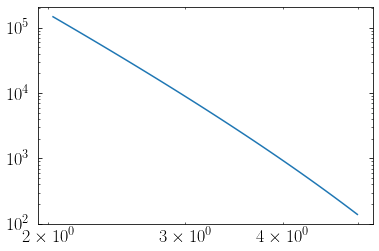

In [7]:
x = bin_midpoints
y = [dNbydM(m,p0,p1,p2) for m in x]
plt.plot(x,y)
plt.semilogy()
plt.semilogx()

In [8]:
bg_bincounts = [np.random.poisson(dNbydM(m,p0,p1,p2)) for m in bin_midpoints]

In [9]:
ndim=2
bgevents = [np.random.normal(0,1,(bincount,ndim)) for bincount in bg_bincounts]

In [10]:
signal_distribution = np.random.normal(2.97,0.06,200)
signal_bincounts = np.histogram(signal_distribution,bins=bin_boundaries)[0]
signal_bincounts

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  3, 33, 97,
       59,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0])

In [11]:
print(signal_bincounts[14:19])
print(bg_bincounts[14:19])
print(signal_bincounts[14:19]/np.sqrt(bg_bincounts[14:19]))
print(signal_bincounts[14:19]/bg_bincounts[14:19])

[ 3 33 97 59  7]
[13762, 11652, 9834, 8166, 6604]
[0.02557293 0.30571286 0.97815264 0.65290099 0.08613795]
[0.00021799 0.00283213 0.00986374 0.00722508 0.00105996]


In [12]:
signal_center = np.ones(ndim)*1.5
signal_variances = np.ones(ndim)*0.08**2
signal_cov = np.diag(signal_variances)
signalevents = [np.random.multivariate_normal(signal_center,
                                              signal_cov,
                                              bincount)
                for bincount in signal_bincounts]

bg_plus_signal_binned = [np.random.permutation(np.append(signalevents[i],bgevents[i],axis=0)) for i in range(len(signalevents))]

(-4, 4)

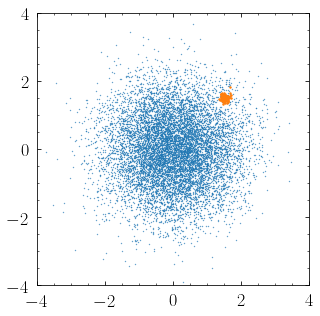

In [13]:
plt.figure(figsize=(5,5))
plt.scatter(bgevents[16][:,0],bgevents[16][:,1],s=0.1)
plt.scatter(signalevents[16][:,0],signalevents[16][:,1],s=2)
plt.gca().set_aspect(1.)
plt.xlim([-4,4])
plt.ylim([-4,4])

In [14]:
from __future__ import print_function
#import os
import gc
import sys
import numpy as np
import numpy.random as rand
import math
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import stats
import keras as keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
#import pickle as pickle
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
import time
import glob
import numpy.ma as ma
from keras import backend as K
K.set_session(sess)

from cwola_utils_copy import AddPredictionsToScatter_nestedcrossval
from cwola_utils_copy import model_ensemble
from cwola_utils_copy import check_eff
from cwola_utils_copy import print_scatter_checkpoint
from cwola_utils_copy import get_p_value

/home/Jack/.virtualenvs/Keras/lib/python3.4/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/home/Jack/.virtualenvs/Keras/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)
Using TensorFlow backend.


In [15]:
myargs={}

if '-o' not in myargs:
    print("Setting default output name '-o': '~/model'")
    myargs['-o'] = "~/model"
if '-in' not in myargs:
    print("Setting default input directory to '/data1/users/jcollins/'")
    myargs['-in'] = '/data1/users/jcollins/'
if '-bin' not in myargs:
    myargs['-bin'] = 7
    print("Setting default bin '-bin':", myargs['-bin'])
else:
    myargs['-bin'] = int(myargs['-bin'])
if '-it' not in myargs:
    myargs['-it'] = 3
    print("Setting default  '-it':", myargs['-it'])
else:
    myargs['-it'] = int(myargs['-it'])
    
if '-kfold' not in myargs:
    myargs['-kfold'] = 5
    print("Setting default  '-kfold':",myargs['-kfold'])
else:
    myargs['-kfold'] = int(myargs['-kfold'])
    
if '-signal' not in myargs:
    myargs['-signal'] = 1
    print("Setting default  '-signal':",myargs['-signal'])
else:
    myargs['-signal'] = int(myargs['-signal'])
    
if '-sigevnts' not in myargs:
    myargs['-sigevnts'] = 1125
    print("Setting default  '-sigevnts':",myargs['-sigevnts'])
else:
    myargs['-sigevnts'] = int(myargs['-sigevnts'])
if '-bgevnts' not in myargs:
    myargs['-bgevnts'] = 553388
    print("Setting default  '-bgevnts':", myargs['-bgevnts'])
else:
    myargs['-bgevnts'] = int(myargs['-bgevnts'])
if '-bgoffset' not in myargs:
    myargs['-bgoffset'] = 0
    print("Setting default  '-bgoffset':", myargs['-bgoffset'])
else:
    myargs['-bgoffset'] = int(myargs['-bgoffset'])

if '-batchsize' not in myargs:
    myargs['-batchsize'] = 5000
    print("Setting default  '-batchsize':", myargs['-batchsize'])
else:
    myargs['-batchsize'] = int(myargs['-batchsize'])
if '-patience' not in myargs:
    myargs['-patience'] = 250
    print("Setting default  '-patience':", myargs['-patience'])
else:
    myargs['-patience'] = int(myargs['-patience'])
if '-checkeff' not in myargs:
    myargs['-checkeff'] = 0.01
    print("Setting default  '-checkeff':", myargs['-checkeff'])
else:
    myargs['-checkeff'] = float(myargs['-checkeff'])

if '-loadonly' not in myargs:
    myargs['-loadonly'] = 0
    print("Setting default  '-loadonly':", myargs['-loadonly'])
else:
    myargs['-loadonly'] = float(myargs['-loadonly'])
if '-trainonly' not in myargs:
    myargs['-trainonly'] = 0
    print("Setting default  '-trainonly':", myargs['-trainonly'])
else:
    myargs['-trainonly'] = int(myargs['-trainonly'])

    
if '-startk' not in myargs:
    myargs['-startk'] = 0
    print("Setting default  '-startk':", myargs['-startk'])
else:
    myargs['-startk'] = int(myargs['-startk'])
if '-startl' not in myargs:
    myargs['-startl'] = 0
    print("Setting default  '-startl':", myargs['-startl'])
else:
    myargs['-startl'] = int(myargs['-startl'])
if '-endk' not in myargs:
    myargs['-endk'] = 0
    print("Setting default  '-endk':", myargs['-endk'])
else:
    myargs['-endk'] = int(myargs['-endk'])
if '-endl' not in myargs:
    myargs['-endl'] = 0
    print("Setting default  '-endl':", myargs['-endl'])
else:
    myargs['-endl'] = int(myargs['-endl'])

Setting default output name '-o': '~/model'
Setting default input directory to '/data1/users/jcollins/'
Setting default bin '-bin': 7
Setting default  '-it': 3
Setting default  '-kfold': 5
Setting default  '-signal': 1
Setting default  '-sigevnts': 1125
Setting default  '-bgevnts': 553388
Setting default  '-bgoffset': 0
Setting default  '-batchsize': 5000
Setting default  '-patience': 250
Setting default  '-checkeff': 0.01
Setting default  '-loadonly': 0
Setting default  '-trainonly': 0
Setting default  '-startk': 0
Setting default  '-startl': 0
Setting default  '-endk': 0
Setting default  '-endl': 0


 k = 0 l = 1
Now training model  1  of  1


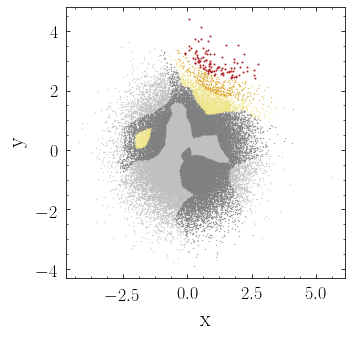

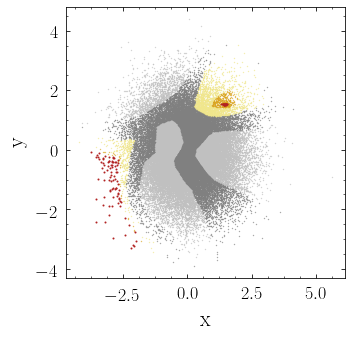

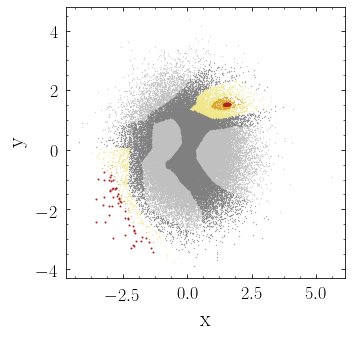

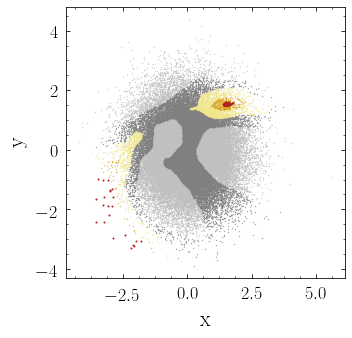

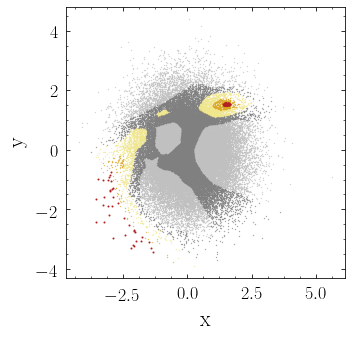

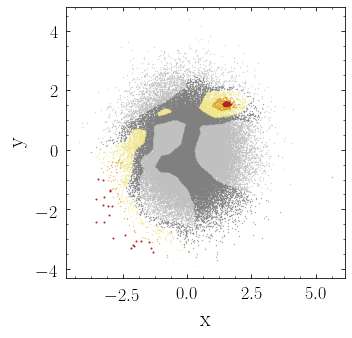

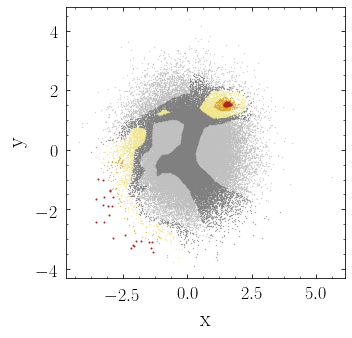

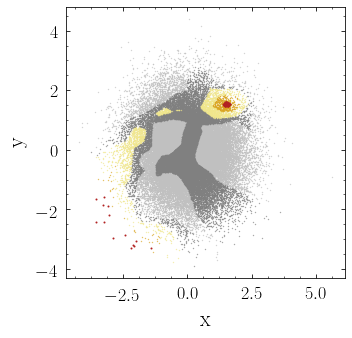

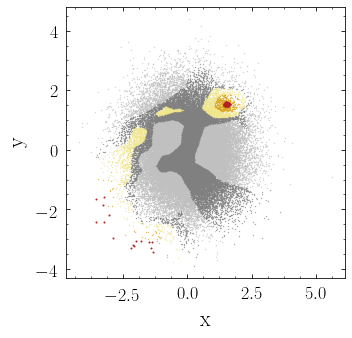

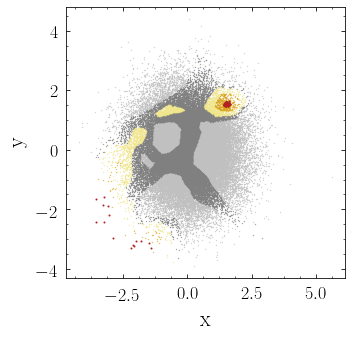

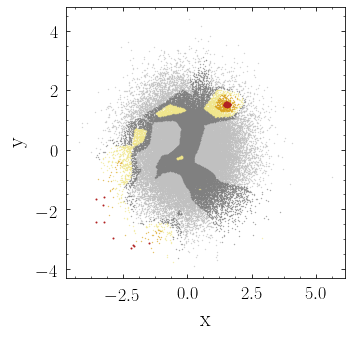

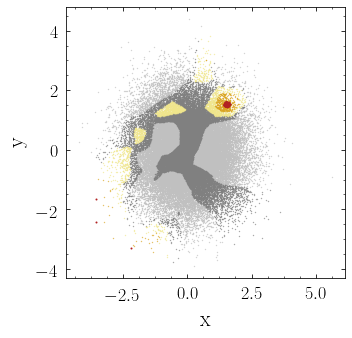

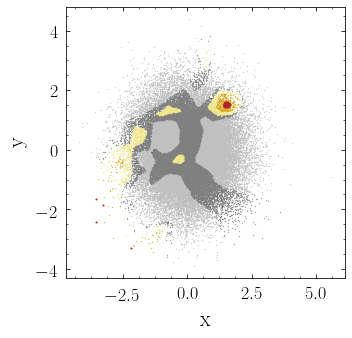

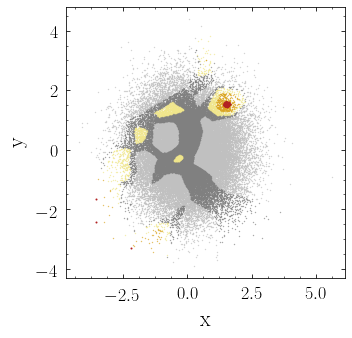

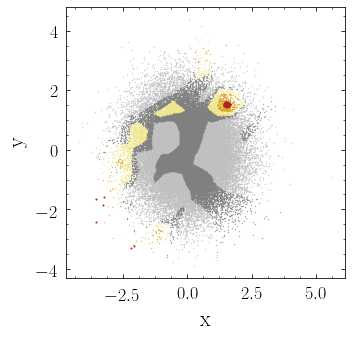

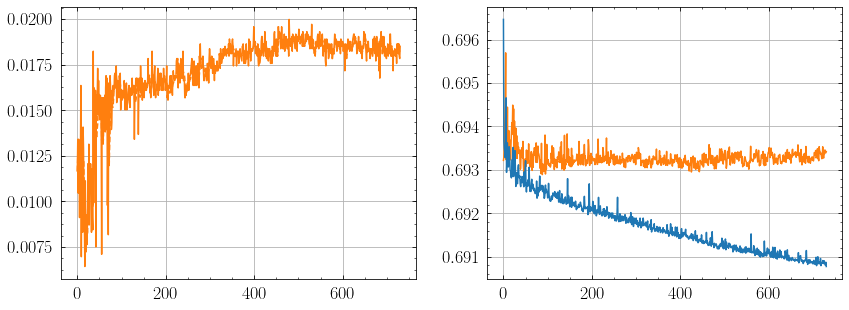

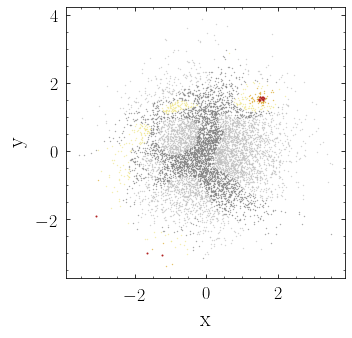

Saving fig testing_16_[0,1]_0_scatterk_0.png
Elapsed Time =  486.009286403656


In [16]:
output_prefix = 'testing'
myargs['-kfold']=4
kfolds = 4
eff_for_thresh=0.01
myargs['-patience'] = 200
ntries = 1

bin_i=16
axes_list=[[0,1]]
axes_labels=[['x','y']]
preprocess=None
numvars=2
batch_size=2000

rates = np.array([0.5,0.95,0.99,0.998]),
colors=['silver','grey','khaki','goldenrod','firebrick']

times = list()


myargs['-checkeff']

model_utils = model_ensemble(bg_plus_signal_binned, bin_i = bin_i, kfolds=kfolds, eff_for_thresh = eff_for_thresh)

i=0
k=0
l=1

print(" k =", k, "l =", l)
#Naming convention for model files.
checkpoint_name = output_prefix + "_" + str(bin_i) + "_[" + str(k) + "," + str(l) + "]_" + str(i)
start = time.time()

data_train, data_valid, labels_train, labels_valid, weights_train, weights_valid = model_utils.get_trainval_data(k,l)

print("Now training model ", i + 1, " of ", ntries)

K.clear_session()
#Following hyperparams seem to work well. Not done systematic optimization. Maybe something else works much better.
myoptimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.8, beta_2=0.99, epsilon=1e-08, decay=0.0005)

#Custom callback to record tpr at fixed fpr (set by eff_rate), where tpr and fpr refer to signal and sideband regions rather than truth-labels.
my_check_eff = check_eff(verbose=0, filename = checkpoint_name + '_best.h5', patience = myargs['-patience'],
                         min_epoch=10, batch_size=batch_size,
                         plot_period=2,eff_rate=myargs['-checkeff'],
                         plotmode="print")
#Custom callback for printing scatter plots every few epochs. Useful for troubleshooting, but slows down training considerably.
my_print = print_scatter_checkpoint(filename = checkpoint_name,
                                    axes_list = axes_list,
                                    axes_labels = axes_labels,
                                    period=50,
                                    training_data=np.append(data_train,data_valid,axis=0),
                                    preprocess=preprocess,
                                   rates=rates,
                                   colors=colors)

mycallbacks=[my_print,
    my_check_eff]

#Following seems to work well for benchmarks. Not systematically optimized. I basically just played around until something worked.
#However, bias initialization seems very important. Keras relu by default initializes to 0 bias, and especially in the first layer will not move from that initialization during training. This is very suboptimal.
model = Sequential()
model.add(Dense(64, input_dim=numvars,use_bias=True,
                #activation='relu',
                bias_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.5)))
model.add(keras.layers.LeakyReLU(alpha=0.01))
#model.add(Activation('tanh'))
#model.add(Dropout(0.1))
model.add(Dense(32, use_bias=True, activation='elu',
                bias_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.2)))
#model.add(Dropout(0.1))
model.add(Dense(32, use_bias=True, activation='elu',
                bias_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.2)))
#model.add(Dropout(0.1))
model.add(Dense(16, use_bias=True, activation='elu',
                bias_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.2)))
model.add(Dense(8, use_bias=True, activation='elu',
                bias_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.2)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=myoptimizer,
              loss='binary_crossentropy')

model_hist = model.fit(data_train, labels_train, epochs=2000, batch_size=batch_size,
                       validation_data=(data_valid, labels_valid, weights_valid),
                       callbacks=mycallbacks,verbose=0,
                       sample_weight = weights_train)

del model
K.clear_session()           #Otherwise TensorFlow eats up all GPU memory with previous models.


model = keras.models.load_model(checkpoint_name + "_best.h5")
model_utils.add_model(model, None, k, l,checkpoint_name + "_best.h5")
plt.close('all')


model_utils.print_scatter_onemodel_signalregion(k,l,i,axes_list=axes_list,axes_labels=axes_labels,
                                                       rates=rates,
                                                       colors=colors)
figfile=checkpoint_name + '_scatterk_' + str(k) + '.png'
print('Saving fig', figfile)
plt.savefig(figfile)

for i in range(5):
    gc.collect()
end = time.time()

times.append(end-start)
print("Elapsed Time = ", times[-1])
sys.stdout.flush()

Starting kfold 0 of 3
Starting lfold 1 of 3
 k = 0 l = 1
Now training model  1  of  1


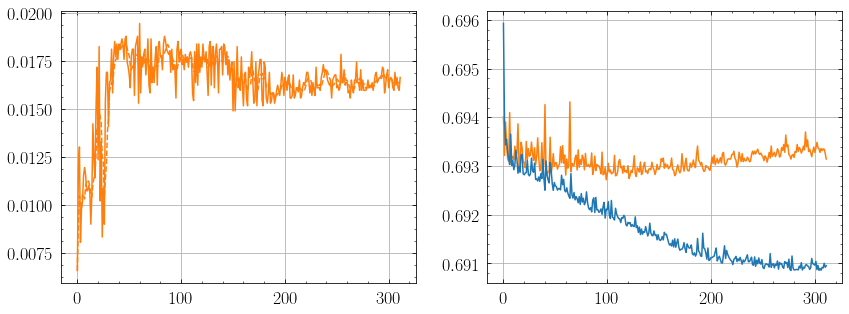

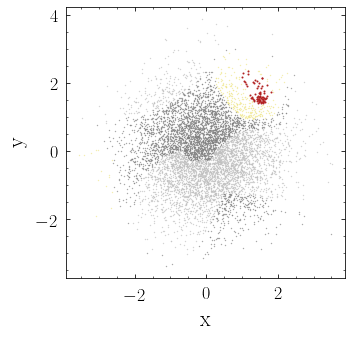

Saving fig testing_16_[0,1]_0_scatterk_0.png
Elapsed Time =  230.22790551185608
Starting lfold 2 of 3
 k = 0 l = 2
Now training model  1  of  1


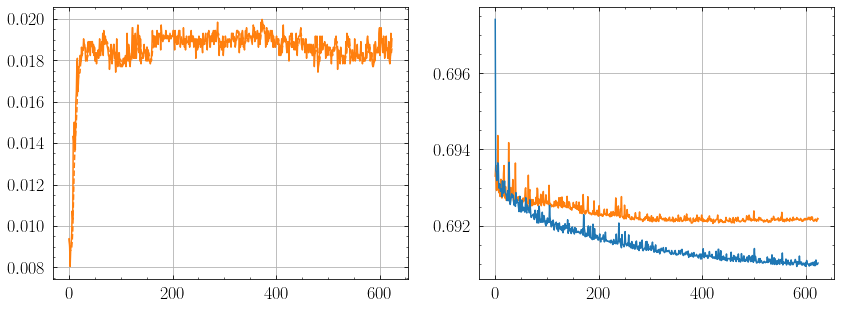

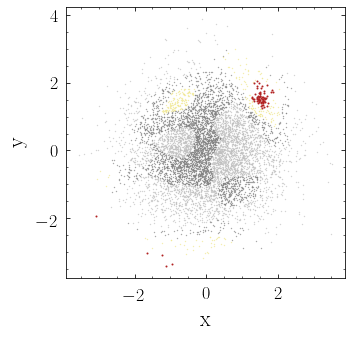

Saving fig testing_16_[0,2]_0_scatterk_0.png
Elapsed Time =  432.25637102127075
Starting lfold 3 of 3
 k = 0 l = 3
Now training model  1  of  1


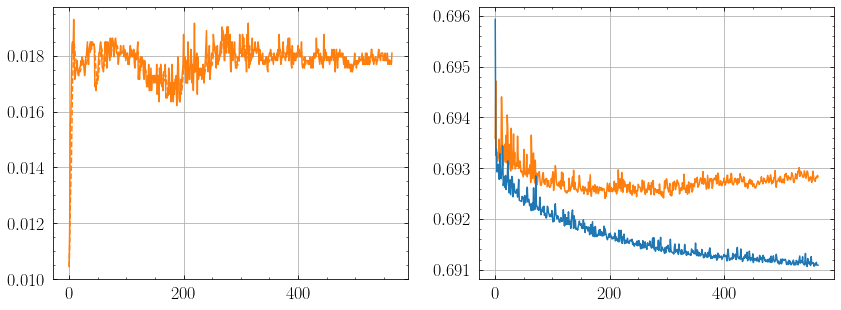

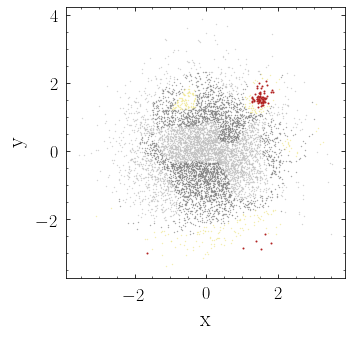

Saving fig testing_16_[0,3]_0_scatterk_0.png
Elapsed Time =  418.5151364803314
Bin =  16
aucs valid:  [[[0.5062551746569941], [0.5096947104011743], [0.5006004472298351]], [[], [], []], [[], [], []], [[], [], []]]
Effs valid:  [[[0.01943699731903481], [0.019973190348525516], [0.019163763066202044]], [[], [], []], [[], [], []], [[], [], []]]
aucs train:  [[[0.5141873602221924], [0.5236110831591817], [0.521448732101626]], [[], [], []], [[], [], []], [[], [], []]]
Effs train:  [[[0.019903498190591118], [0.01849618013671095], [0.01729222520107243]], [[], [], []], [[], [], []], [[], [], []]]


Ensemble model for k = 0


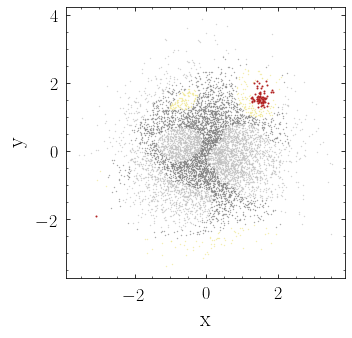

Starting kfold 1 of 3
Starting lfold 0 of 3
 k = 1 l = 0
Now training model  1  of  1


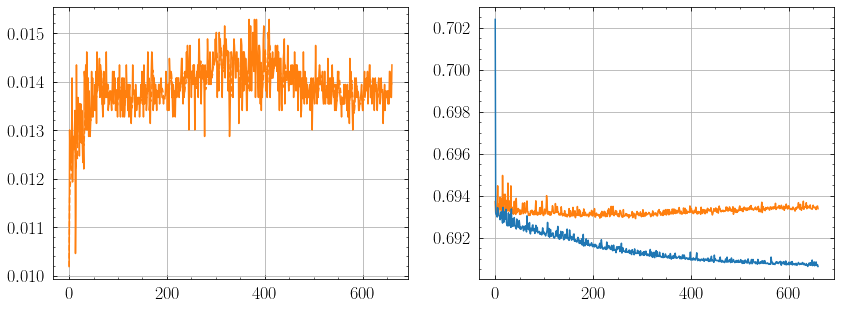

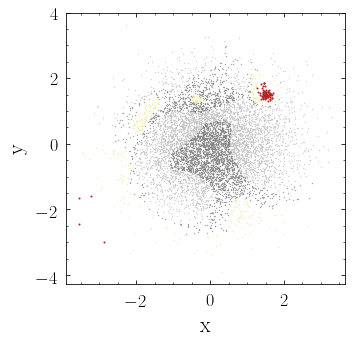

Saving fig testing_16_[1,0]_0_scatterk_1.png
Elapsed Time =  477.37582635879517
Starting lfold 2 of 3
 k = 1 l = 2
Now training model  1  of  1


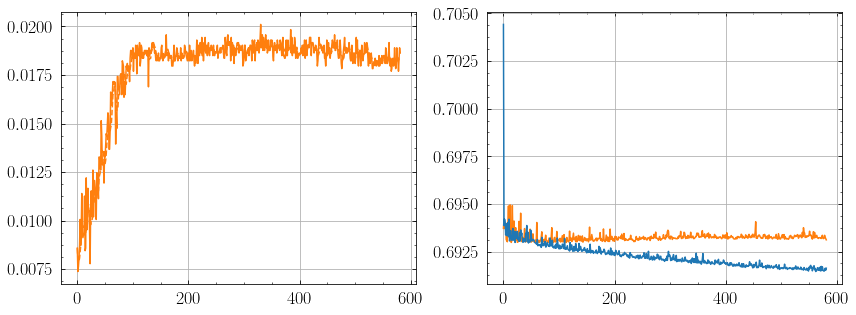

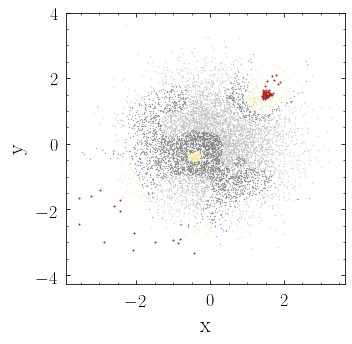

Saving fig testing_16_[1,2]_0_scatterk_1.png
Elapsed Time =  333.83737564086914
Starting lfold 3 of 3
 k = 1 l = 3
Now training model  1  of  1


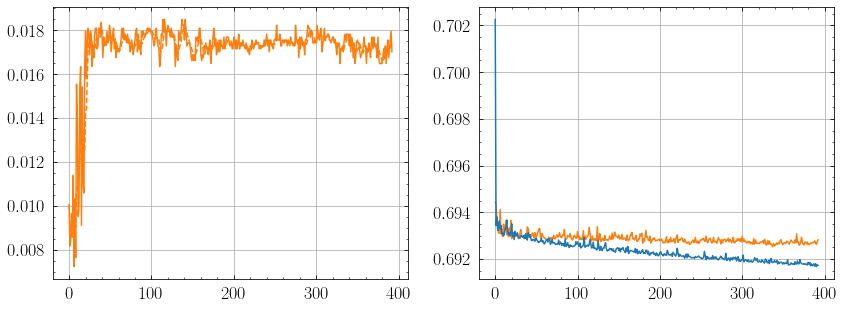

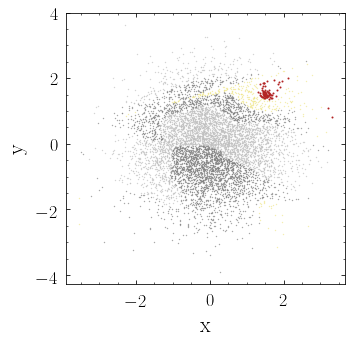

Saving fig testing_16_[1,3]_0_scatterk_1.png
Elapsed Time =  188.8452582359314
Bin =  16
aucs valid:  [[[0.5062551746569941], [0.5096947104011743], [0.5006004472298351]], [[0.5101367960932045], [0.5015255318460649], [0.5071147789705983]], [[], [], []], [[], [], []]]
Effs valid:  [[[0.01943699731903481], [0.019973190348525516], [0.019163763066202044]], [[0.015283550073736385], [0.020107238605898137], [0.01849370142053064]], [[], [], []], [[], [], []]]
aucs train:  [[[0.5141873602221924], [0.5236110831591817], [0.521448732101626]], [[0.5233733827945408], [0.5221027135573649], [0.518649498972905]], [[], [], []], [[], [], []]]
Effs train:  [[[0.019903498190591118], [0.01849618013671095], [0.01729222520107243]], [[0.019099316445516656], [0.019167616111520625], [0.01595281185066022]], [[], [], []], [[], [], []]]


Ensemble model for k = 1


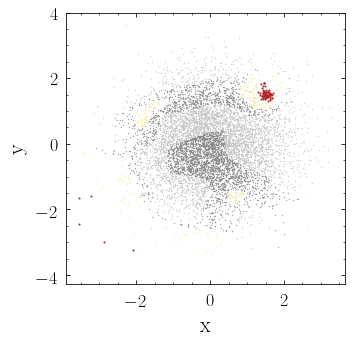

Starting kfold 2 of 3
Starting lfold 0 of 3
 k = 2 l = 0
Now training model  1  of  1


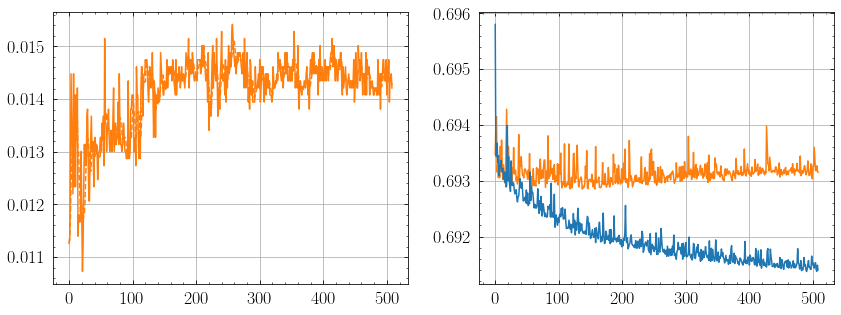

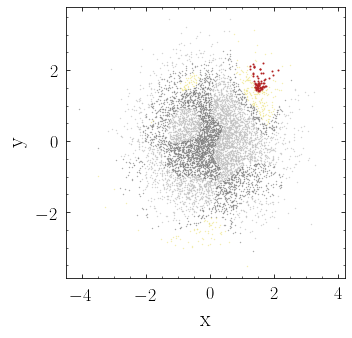

Saving fig testing_16_[2,0]_0_scatterk_2.png
Elapsed Time =  230.77076387405396
Starting lfold 1 of 3
 k = 2 l = 1
Now training model  1  of  1


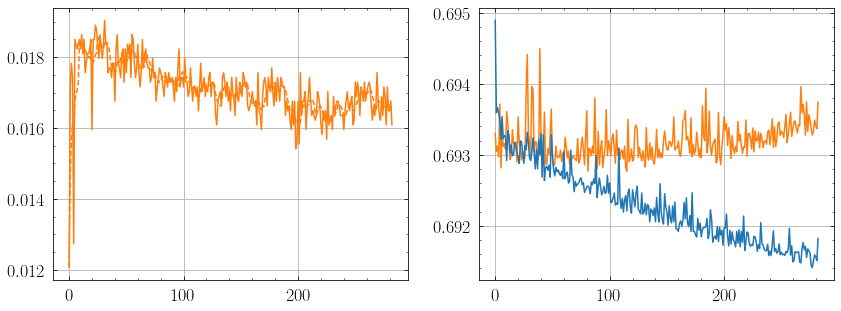

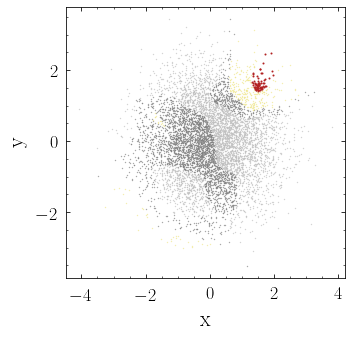

Saving fig testing_16_[2,1]_0_scatterk_2.png
Elapsed Time =  124.00087571144104
Starting lfold 3 of 3
 k = 2 l = 3
Now training model  1  of  1


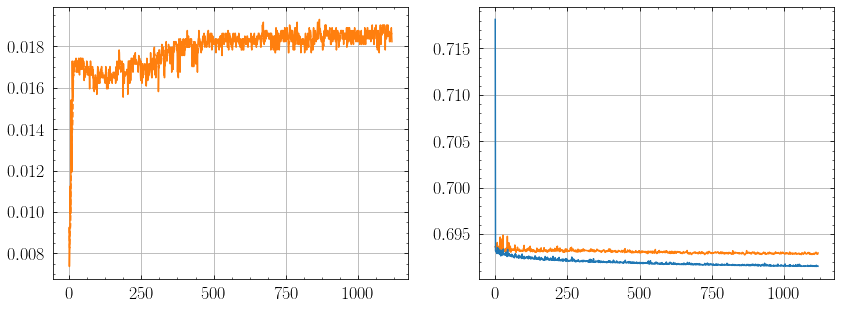

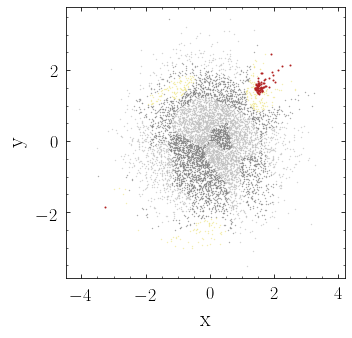

Saving fig testing_16_[2,3]_0_scatterk_2.png
Elapsed Time =  497.8826882839203
Bin =  16
aucs valid:  [[[0.5062551746569941], [0.5096947104011743], [0.5006004472298351]], [[0.5101367960932045], [0.5015255318460649], [0.5071147789705983]], [[0.511761890894562], [0.5041583455149434], [0.5094290998994339]], [[], [], []]]
Effs valid:  [[[0.01943699731903481], [0.019973190348525516], [0.019163763066202044]], [[0.015283550073736385], [0.020107238605898137], [0.01849370142053064]], [[0.015417616302453419], [0.019034852546916836], [0.019297775395336392]], [[], [], []]]
aucs train:  [[[0.5141873602221924], [0.5236110831591817], [0.521448732101626]], [[0.5233733827945408], [0.5221027135573649], [0.518649498972905]], [[0.5240614092707093], [0.5138092183059033], [0.5244585097542505]], [[], [], []]]
Effs train:  [[[0.019903498190591118], [0.01849618013671095], [0.01729222520107243]], [[0.019099316445516656], [0.019167616111520625], [0.01595281185066022]], [[0.01708886208283067], [0.0178942430132028

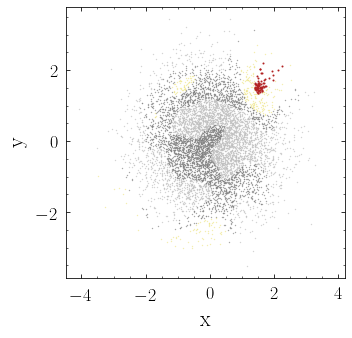

Starting kfold 3 of 3
Starting lfold 0 of 3
 k = 3 l = 0
Now training model  1  of  1


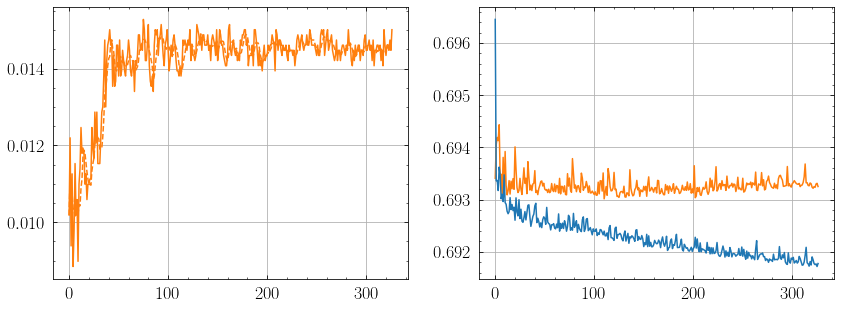

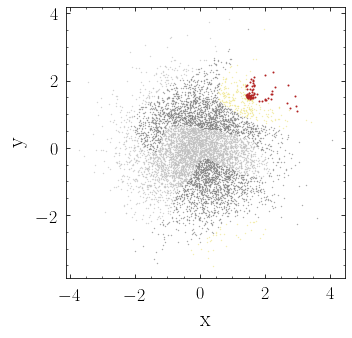

Saving fig testing_16_[3,0]_0_scatterk_3.png
Elapsed Time =  148.96770763397217
Starting lfold 1 of 3
 k = 3 l = 1
Now training model  1  of  1


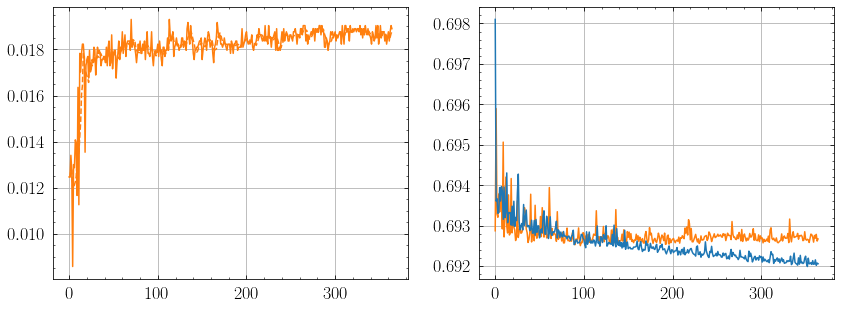

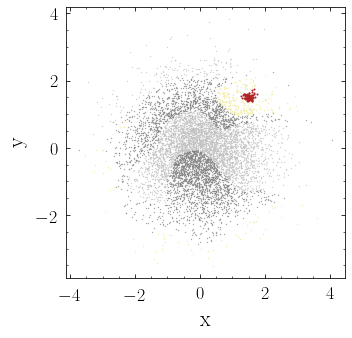

Saving fig testing_16_[3,1]_0_scatterk_3.png
Elapsed Time =  157.04469680786133
Starting lfold 2 of 3
 k = 3 l = 2
Now training model  1  of  1


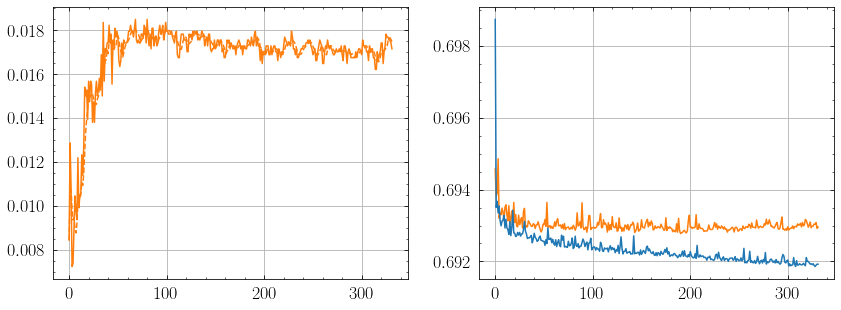

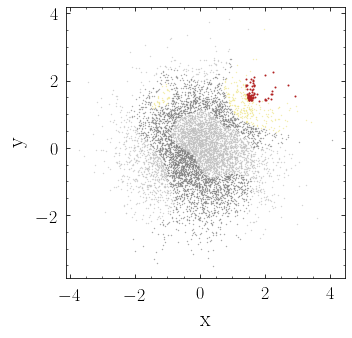

Saving fig testing_16_[3,2]_0_scatterk_3.png
Elapsed Time =  152.8551778793335
Bin =  16
aucs valid:  [[[0.5062551746569941], [0.5096947104011743], [0.5006004472298351]], [[0.5101367960932045], [0.5015255318460649], [0.5071147789705983]], [[0.511761890894562], [0.5041583455149434], [0.5094290998994339]], [[0.5037336484011901], [0.5079725099980186], [0.5088797177202495]]]
Effs valid:  [[[0.01943699731903481], [0.019973190348525516], [0.019163763066202044]], [[0.015283550073736385], [0.020107238605898137], [0.01849370142053064]], [[0.015417616302453419], [0.019034852546916836], [0.019297775395336392]], [[0.015283550073736385], [0.01930294906166219], [0.01849865951742624]]]
aucs train:  [[[0.5141873602221924], [0.5236110831591817], [0.521448732101626]], [[0.5233733827945408], [0.5221027135573649], [0.518649498972905]], [[0.5240614092707093], [0.5138092183059033], [0.5244585097542505]], [[0.5179554611143797], [0.517020389724891], [0.5168864130532903]]]
Effs train:  [[[0.019903498190591118]

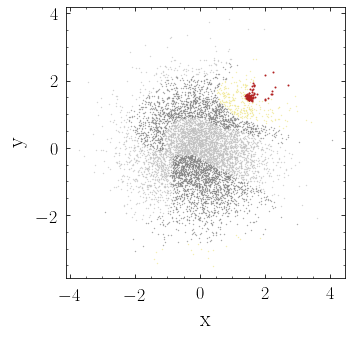

/home/Jack/.virtualenvs/Keras/lib/python3.4/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [17]:
output_prefix = 'testing'
myargs['-kfold']=4
kfolds = 4
eff_for_thresh=0.01
myargs['-patience'] = 100
ntries = 1

bin_i=16
axes_list=[[0,1]]
axes_labels=[['x','y']]
preprocess=None
numvars=2
batch_size=2000

rates = np.array([0.5,0.95,0.99]),
colors=['silver','grey','khaki','firebrick']

times = list()


myargs['-checkeff']

model_utils = model_ensemble(bg_plus_signal_binned, bin_i = bin_i, kfolds=kfolds, eff_for_thresh = eff_for_thresh)
for k in range(myargs['-kfold']):
    print('Starting kfold', k, 'of', kfolds-1)
    #Loop over validation sets
    for l in range(myargs['-kfold']):
        if l == k:
            continue
        print('Starting lfold', l, 'of', kfolds-1)

        data_train, data_valid, labels_train, labels_valid, weights_train, weights_valid = model_utils.get_trainval_data(k,l)

        for i in range(ntries):
            print(" k =", k, "l =", l)
            #Naming convention for model files.
            checkpoint_name = output_prefix + "_" + str(bin_i) + "_[" + str(k) + "," + str(l) + "]_" + str(i)
            start = time.time()


            print("Now training model ", i + 1, " of ", ntries)

            K.clear_session()
            #Following hyperparams seem to work well. Not done systematic optimization. Maybe something else works much better.
            myoptimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.8, beta_2=0.99, epsilon=1e-08, decay=0.0005)

            #Custom callback to record tpr at fixed fpr (set by eff_rate), where tpr and fpr refer to signal and sideband regions rather than truth-labels.
            my_check_eff = check_eff(verbose=0, filename = checkpoint_name + '_best.h5', patience = myargs['-patience'],
                                     min_epoch=10, batch_size=batch_size,
                                     plot_period=2,eff_rate=myargs['-checkeff'],
                                     plotmode="print")
            #Custom callback for printing scatter plots every few epochs. Useful for troubleshooting, but slows down training considerably.
            my_print = print_scatter_checkpoint(filename = checkpoint_name,
                                                axes_list = axes_list,
                                                axes_labels = axes_labels,
                                                period=50,
                                                training_data=np.append(data_train,data_valid,axis=0),
                                                preprocess=preprocess,
                                               rates=rates,
                                               colors=colors)

            mycallbacks=[#my_print,
                my_check_eff]

            #Following seems to work well for benchmarks. Not systematically optimized. I basically just played around until something worked.
            #However, bias initialization seems very important. Keras relu by default initializes to 0 bias, and especially in the first layer will not move from that initialization during training. This is very suboptimal.
            model = Sequential()
            model.add(Dense(64, input_dim=numvars,use_bias=True,
                            #activation='relu',
                            bias_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.5)))
            model.add(keras.layers.LeakyReLU(alpha=0.01))
            #model.add(Activation('tanh'))
            #model.add(Dropout(0.1))
            model.add(Dense(32, use_bias=True, activation='elu',
                            bias_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.2)))
            #model.add(Dropout(0.1))
            model.add(Dense(32, use_bias=True, activation='elu',
                            bias_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.2)))
            #model.add(Dropout(0.1))
            model.add(Dense(16, use_bias=True, activation='elu',
                            bias_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.2)))
            model.add(Dense(8, use_bias=True, activation='elu',
                            bias_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.2)))
            model.add(Dense(1, activation='sigmoid'))

            model.compile(optimizer=myoptimizer,
                          loss='binary_crossentropy')

            model_hist = model.fit(data_train, labels_train, epochs=2000, batch_size=batch_size,
                                   validation_data=(data_valid, labels_valid, weights_valid),
                                   callbacks=mycallbacks,verbose=0,
                                   sample_weight = weights_train)

            del model
            K.clear_session()           #Otherwise TensorFlow eats up all GPU memory with previous models.


            model = keras.models.load_model(checkpoint_name + "_best.h5")
            model_utils.add_model(model, None, k, l,checkpoint_name + "_best.h5")
            plt.close('all')
            


            model_utils.print_scatter_onemodel_signalregion(k,l,i,axes_list=axes_list,axes_labels=axes_labels,
                                                                   rates=rates,
                                                                   colors=colors)
            figfile=checkpoint_name + '_scatterk_' + str(k) + '.png'
            print('Saving fig', figfile)
            plt.savefig(figfile)

            for i in range(5):
                gc.collect()
            end = time.time()

            times.append(end-start)
            print("Elapsed Time = ", times[-1])
            sys.stdout.flush()

    print("Bin = ", bin_i)
    print("aucs valid: ", model_utils.aucs_valid)
    print("Effs valid: ", model_utils.effs_valid)
    print("aucs train: ", model_utils.aucs_train)
    print("Effs train: ", model_utils.effs_train)
    print("\n")

    #Make an ensemble model 7using the average of the best models trained using the (k-1) training-validation splits. Save this as a single model.
    ensemble_model = model_utils.makeandsave_ensemble_model(k,output_prefix + "_" + str(bin_i) + "_ensemble_k" + str(k) + ".h5")
    plt.close('all')
    
    print("Ensemble model for k =", k)
    model_utils.print_scatter_avg_onek_signalregion(k,axes_list=axes_list,axes_labels=axes_labels,
                                                                   rates=rates,
                                                                   colors=colors)
    del ensemble_model
    K.clear_session()
    sys.stdout.flush()

model_utils.load_all_ensemble_models()

In [28]:
bin_widths_GeV = bin_widths*1000
bin_boundaries_GeV = bin_boundaries*1000

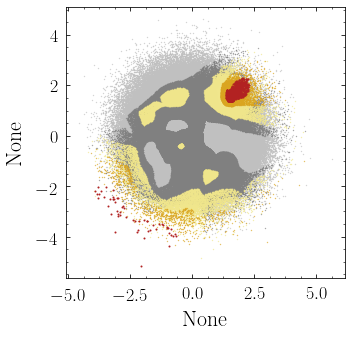

Setting eff to  1.0
Counts after cut:  [147474 125361 106643  89884  75598  64699  54745  45816  38887  32974
  27662  23284  19449  16408  13765  11685   9931   8225   6611   5647
   4726   3977   3297   2761   2304   1930   1624   1257   1060    910
    681    615    487    386    343    235    228    164    138]
Setting eff to  0.1
Counts after cut:  [14820 12403 10485  8974  7673  6586  5486  4521  3972  3260  2735  2404
  1901  1668  1312  1123  1063   859   657   526   476   416   350   263
   218   226   148   119   110   110    64    54    51    49    27    23
    25    16    12]
Setting eff to  0.05
Counts after cut:  [7312 6080 5291 4511 3872 3293 2783 2222 1979 1632 1340 1181  961  854
  649  599  579  471  331  272  237  207  183  129   93  115   79   64
   53   59   38   25   27   22   14    9   13    7    6]
Setting eff to  0.02
Counts after cut:  [2892 2413 2061 1813 1550 1315 1112  888  781  664  541  453  372  346
  261  271  288  227  126   99   98   94   67   52   37

In [47]:
from importlib import reload  # Python 3.4+ only.
import cwola_utils_copy
from cwola_utils_copy import get_p_value

key=18
kset_data, kset_prediction = model_utils.avg_model_predict_kset()
plt.close('all')

AddPredictionsToScatter_nestedcrossval(kset_data,kset_prediction,axes_list = axes_list,
                                        rates = np.array([0.5,0.95,0.99,0.998]),
                                        colors=['silver','grey','khaki','goldenrod','firebrick'])



chosen_effs = [1.0,0.1,0.05,0.02,0.01,0.005,0.002,0.001,0.0005]

ymin=1E8
ymax=0
plt.close('all')

file = open(output_prefix + '_' + str(bin_i) +  '_bincounts.dat','w')
bincutcountslist = []

for eff in chosen_effs:
    print("Setting eff to ", eff)
    bincutcounts, bincutcountsset = model_utils.get_bin_cut_counts_all(eff)
    bindensities = bincutcounts / bin_widths_GeV
    print("Counts after cut: ", bincutcounts)
    #print("St. Dev. after cut: ", binstd)
    file.write(str(eff))
    file.write('\t')
    for entry in bincutcounts:
        file.write(str(entry))
        file.write('\t')
    file.write('\n')
    bincutcountslist.append(bincutcounts)



file.close()


Getting p-value for eff: 1.0
fit params:  [1.43725272 4.84459993 7.0531571 ]


Goodness:  KstestResult(statistic=0.10868820070936369, pvalue=0.7970512166376129)


numerator:  dict_items([('success', True), ('x', array([80.72492186])), ('nfev', 22), ('hess_inv', <1x1 LbfgsInvHessProduct with dtype=float64>), ('fun', -0.4102211469435133), ('jac', array([0.])), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('nit', 4)]) 

Denominator:  dict_items([('success', True), ('x', array([-15.62735973, 452.03047341])), ('nfev', 99), ('hess_inv', <2x2 LbfgsInvHessProduct with dtype=float64>), ('fun', -2.8228283467469737), ('jac', array([0., 0.])), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('nit', 9)]) 

z =  2.2029286717825047
p0 =  0.013799888201328048


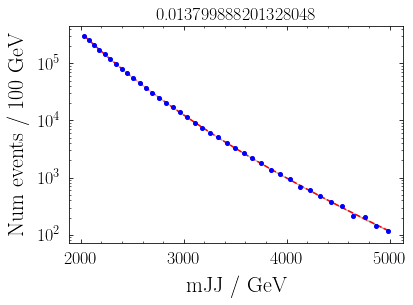

Getting p-value for eff: 0.1
fit params:  [0.16705998 5.08713109 6.99327056]


Goodness:  KstestResult(statistic=0.14761836821894947, pvalue=0.3781466803097613)


numerator:  dict_items([('success', True), ('x', array([16.03420469])), ('nfev', 16), ('hess_inv', <1x1 LbfgsInvHessProduct with dtype=float64>), ('fun', -0.28462465372285806), ('jac', array([0.])), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('nit', 4)]) 

Denominator:  dict_items([('success', True), ('x', array([-2.11996370e-02,  1.04255092e+02])), ('nfev', 21), ('hess_inv', <2x2 LbfgsInvHessProduct with dtype=float64>), ('fun', -1.801072497615678), ('jac', array([0., 0.])), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('nit', 5)]) 

z =  1.761514533641948
p0 =  0.03907567765900155


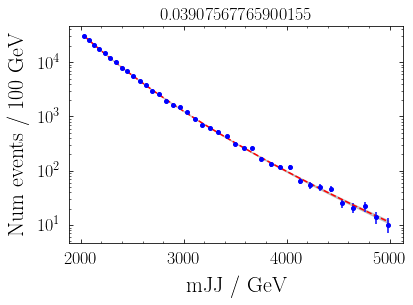

Getting p-value for eff: 0.05
fit params:  [0.12525197 5.67090976 6.82418436]


Goodness:  KstestResult(statistic=0.0865915449350817, pvalue=0.9500478443940031)


numerator:  dict_items([('success', True), ('x', array([26.38964818])), ('nfev', 8), ('hess_inv', <1x1 LbfgsInvHessProduct with dtype=float64>), ('fun', -1.5380989467103063), ('jac', array([0.])), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('nit', 3)]) 

Denominator:  dict_items([('success', True), ('x', array([2.08415727e-02, 1.72545455e+02])), ('nfev', 96), ('hess_inv', <2x2 LbfgsInvHessProduct with dtype=float64>), ('fun', -9.624248224383336), ('jac', array([0., 0.])), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('nit', 9)]) 

z =  4.050101213144459
p0 =  2.5597742580263372e-05


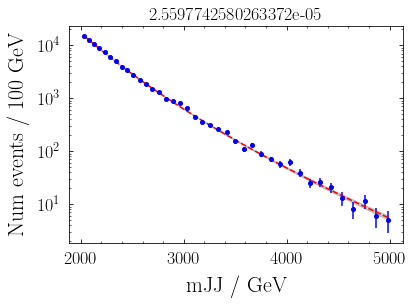

Getting p-value for eff: 0.02
fit params:  [0.09240011 6.67364908 6.58038431]


Goodness:  KstestResult(statistic=0.10396318032282792, pvalue=0.8313199063566654)


numerator:  dict_items([('success', True), ('x', array([29.87593056])), ('nfev', 10), ('hess_inv', <1x1 LbfgsInvHessProduct with dtype=float64>), ('fun', -5.078484685227522), ('jac', array([0.])), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('nit', 4)]) 

Denominator:  dict_items([('success', True), ('x', array([2.33601525e-03, 2.00125707e+02])), ('nfev', 30), ('hess_inv', <2x2 LbfgsInvHessProduct with dtype=float64>), ('fun', -30.48395827819604), ('jac', array([0., 0.])), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('nit', 7)]) 

z =  7.175288922186052
p0 =  3.608224830031759e-13


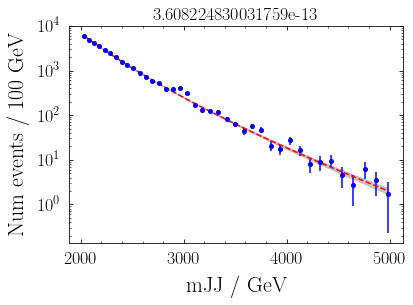

Getting p-value for eff: 0.01
fit params:  [0.03690143 6.42474002 6.67516357]


Goodness:  KstestResult(statistic=0.1094145135930289, pvalue=0.7876373881596079)


numerator:  dict_items([('success', True), ('x', array([27.84335663])), ('nfev', 12), ('hess_inv', <1x1 LbfgsInvHessProduct with dtype=float64>), ('fun', -9.275135344656519), ('jac', array([0.])), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('nit', 5)]) 

Denominator:  dict_items([('success', True), ('x', array([-1.18842007e-03,  1.92876927e+02])), ('nfev', 39), ('hess_inv', <2x2 LbfgsInvHessProduct with dtype=float64>), ('fun', -53.10856065924145), ('jac', array([-4.54747351e-05,  0.00000000e+00])), ('status', 0), ('message', b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'), ('nit', 9)]) 

z =  9.433505593484279
p0 =  0.0


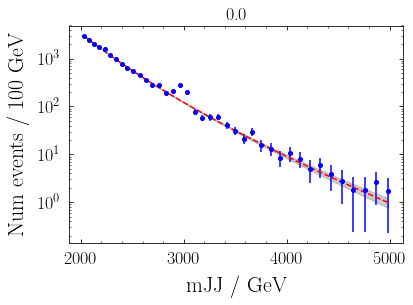

Getting p-value for eff: 0.005
fit params:  [ 0.56707961 11.95205222  5.31492969]


Goodness:  KstestResult(statistic=0.1238293790157291, pvalue=0.6123276448887927)


numerator:  dict_items([('success', True), ('x', array([22.94683573])), ('nfev', 6), ('hess_inv', <1x1 LbfgsInvHessProduct with dtype=float64>), ('fun', -15.444529558967588), ('jac', array([-0.10729764])), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('nit', 2)]) 

Denominator:  dict_items([('success', True), ('x', array([1.19586649e-04, 1.77649420e+02])), ('nfev', 36), ('hess_inv', <2x2 LbfgsInvHessProduct with dtype=float64>), ('fun', -80.74021546151243), ('jac', array([2.27373675e-05, 0.00000000e+00])), ('status', 0), ('message', b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'), ('nit', 9)]) 

z =  11.535323219198668
p0 =  0.0


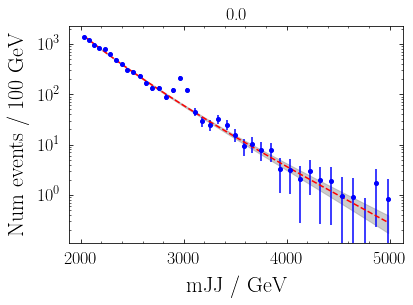

Getting p-value for eff: 0.002
fit params:  [1402.97272067   26.75712328    1.93896358]


Goodness:  KstestResult(statistic=0.15483515520706864, pvalue=0.3213702115764763)


numerator:  dict_items([('success', True), ('x', array([15.28073604])), ('nfev', 6), ('hess_inv', <1x1 LbfgsInvHessProduct with dtype=float64>), ('fun', -18.391364880657648), ('jac', array([-0.28156819])), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('nit', 2)]) 

Denominator:  dict_items([('success', True), ('x', array([-7.33399971e-05,  1.13342594e+02])), ('nfev', 39), ('hess_inv', <2x2 LbfgsInvHessProduct with dtype=float64>), ('fun', -76.08970865862295), ('jac', array([1.13686838e-05, 1.13686838e-05])), ('status', 0), ('message', b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'), ('nit', 10)]) 

z =  10.939783937745077
p0 =  0.0


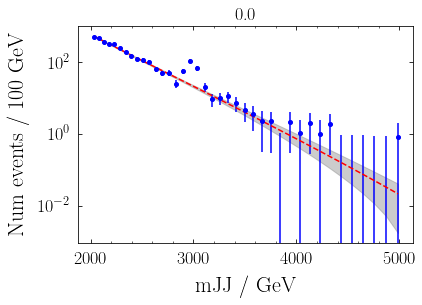

Getting p-value for eff: 0.001
fit params:  [ 0.78626953 16.88342735  4.71873875]


Goodness:  KstestResult(statistic=0.2311464035483711, pvalue=0.03570485787111388)


numerator:  dict_items([('success', True), ('x', array([10.03973752])), ('nfev', 12), ('hess_inv', <1x1 LbfgsInvHessProduct with dtype=float64>), ('fun', -14.286526513339766), ('jac', array([0.])), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('nit', 5)]) 

Denominator:  dict_items([('success', True), ('x', array([2.63513139e-05, 6.82909411e+01])), ('nfev', 33), ('hess_inv', <2x2 LbfgsInvHessProduct with dtype=float64>), ('fun', -55.07592205758942), ('jac', array([-5.68434189e-06, -5.68434189e-06])), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('nit', 9)]) 

z =  9.346569177346959
p0 =  0.0


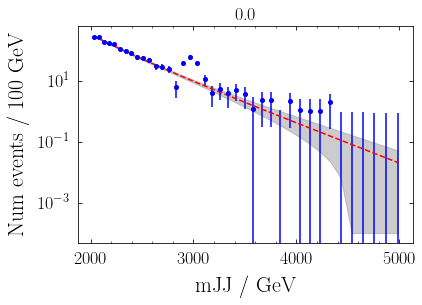

Getting p-value for eff: 0.0005
fit params:  [ 1.43295040e+06  4.27975731e+01 -1.07470093e+00]


Goodness:  KstestResult(statistic=0.21139638458167573, pvalue=0.06861409630227211)


numerator:  dict_items([('success', True), ('x', array([7.88962429])), ('nfev', 12), ('hess_inv', <1x1 LbfgsInvHessProduct with dtype=float64>), ('fun', -12.672132529624918), ('jac', array([-2.84217094e-06])), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('nit', 5)]) 

Denominator:  dict_items([('success', True), ('x', array([-2.42618317e-06,  3.52989248e+01])), ('nfev', 33), ('hess_inv', <2x2 LbfgsInvHessProduct with dtype=float64>), ('fun', -30.303498980770613), ('jac', array([1.42108547e-06, 1.42108547e-06])), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('nit', 10)]) 

z =  6.481605441177421
p0 =  4.537581421715231e-11


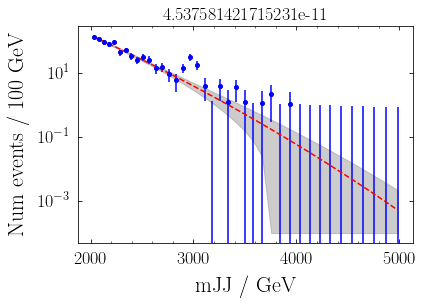

In [46]:
reload(cwola_utils_copy)
from cwola_utils_copy import get_p_value

for i, eff in enumerate(chosen_effs):
    print("Getting p-value for eff:", eff)

    pplotname = output_prefix + '_pplot_' + str(eff) + '.png'
    cwola_utils_copy.get_p_value(bincutcountslist[i],bin_boundaries_GeV,mask=[bin_i-1,bin_i,bin_i+1],verbose=1,
                plotfile="show")